# 5. Score-Based Generative Model (Noise Conditional Score Network)

## 1. Training Stage

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

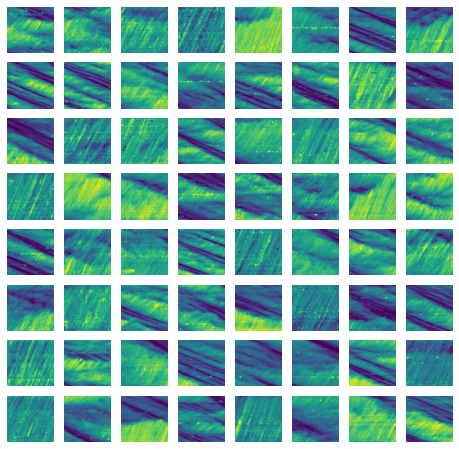

In [2]:
dataset = torch.load('dataset/i24_normalized.pt')

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(dataset[torch.randint(dataset.shape[0], (1,))][0][0], origin="lower" )
        ax[i, j].axis("off")
        
# Create data loaders
data_loader = DataLoader(dataset, batch_size=250, shuffle=True)

In [3]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, n_steps):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(n_steps, num_features * 2)
        
        self.embed.weight.data[:, :num_features].uniform_()
        self.embed.weight.data[:, num_features:].zero_()
            
    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, dim=1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_steps, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.norm1 = ConditionalBatchNorm2d(out_channels, n_steps)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.norm2 = ConditionalBatchNorm2d(out_channels, n_steps)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1) if in_channels != out_channels else nn.Identity()
        self.act = nn.ELU()

    def forward(self, x, y):
        out = self.act(self.norm1(self.conv1(x), y))
        out = self.norm2(self.conv2(out), y)
        out += self.shortcut(x)
        return self.act(out)

class CondRefineNetDilated(nn.Module):
    def __init__(self, n_steps, input_dim):
        super().__init__()
        self.n_steps = n_steps
        self.input_dim = input_dim
        self.num_filter = 128
        
        self.begin_conv = nn.Conv2d(self.input_dim, self.num_filter, kernel_size=3, padding=1)
        self.end_conv = nn.Conv2d(self.num_filter*2, self.input_dim, kernel_size=3, padding=1)
        self.act = nn.ELU()

        self.res1 = ResidualBlock(self.num_filter, self.num_filter, n_steps)
        self.res2 = ResidualBlock(self.num_filter, 2 * self.num_filter, n_steps, dilation=2)
        self.res3 = ResidualBlock(2 * self.num_filter, 2 * self.num_filter, n_steps, dilation=4)
        self.res4 = ResidualBlock(2 * self.num_filter, 2 * self.num_filter, n_steps, dilation=8)

    def forward(self, x, y):
        out = self.act(self.begin_conv(x))
        out = self.res1(out, y)
        out = self.res2(out, y)
        out = self.res3(out, y)
        out = self.res4(out, y)
        out = self.act(out)
        out = self.end_conv(out)
        return out

![alt text](img/Score_based_Generative_Model_edit.png "Title")

The objective function of Score-based Model can be defined as

- $\mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})} \left[\mathbb{E}_{\tilde{\mathbf{x}} \sim q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right)} \left|\left|{ \nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) - s_{\theta} (\tilde{\mathbf{x}} , \sigma)}^2 \right|\right| _2 \right] $

<br/>
<br/>

We are using the normal distribution for the noise. Therefore

- $q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{\left(\tilde{\mathbf{x}}-\mathbf{x} \right)^2}{2 \sigma^2}\right)$

- $\log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)^2}{2 \sigma^2}-\log \left(\sqrt{2 \pi \sigma^2}\right)$

- $\nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)}{\sigma^2}$

<br/>
<br/>

By definition, $\tilde{\mathbf{x}}$ is defined as $\tilde{\mathbf{x}}=\mathbf{x}+\sigma \cdot \epsilon$. Then $\nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right)$ is transformed as

- $ \begin{align} \nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) &= -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)}{\sigma^2} \\ &= -\frac{\left(\mathbf{x}+\sigma \cdot \epsilon-\mathbf{x}\right)}{\sigma^2}\\ &= -\frac{\epsilon}{\sigma}\\ \end{align} $

<br/>
<br/>

Practically, $\sigma^2$ is multiplied to the objective function as the weight.

In [4]:
class Model(nn.Module):
    def __init__(self, n_steps, sigma_min, sigma_max, input_dim):
        super().__init__()
        self.sigmas = np.exp(torch.linspace(
            start=math.log(sigma_max), end=math.log(sigma_min),
            steps=n_steps))
        self.conv_layer = CondRefineNetDilated(n_steps, input_dim)

    def loss_fn(self, x, idx=None):
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)        
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

    def forward(self, x, idx=None, get_target=False):
        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0), 1))
            used_sigmas = self.sigmas[idx][:, :, None, None].to(device)
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            idx = idx.squeeze()
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).long()
            x_tilde = x

        if get_target:
            target = -1 / (used_sigmas) * noise

        output = self.conv_layer(x_tilde, idx.to(device))

        return (output, target, used_sigmas) if get_target else output

The sample is generated by Annealed Langevin Dynamics.

- $\mathbf{x}_{i+1} \leftarrow \mathbf{x}_{i} +  s_{\theta} (\mathbf{x}_i) \cdot \epsilon + \sqrt{2\epsilon} \cdot \mathbf{z}_i$

In [5]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps=1e-1, input_dim=1):
        self.process = np.exp(torch.linspace(
            start=math.log(sigma_max), end=math.log(sigma_min),
            steps=n_steps))
        self.step_size = eps * (self.process / self.process[-1]) ** 2
        self.score_fn = score_fn
        self.annealed_step = annealed_step
        self.input_dim = input_dim
        
    # One iteration of annealed step
    def _one_annealed_step_iteration(self, x, idx):
        self.score_fn.eval()
        z, step_size = torch.randn_like(x), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x
        
    # One Langevin Step
    def _one_diffusion_step(self, x):
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        sample = torch.rand([sampling_number, self.input_dim, 64, 64]).to(device)
        sampling_list = []
        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
        return final if only_final else torch.stack(sampling_list)

In [6]:
# epsilon of step size
eps = 1e-4

# sigma min and max of Langevin dynamic
sigma_min = 0.05
sigma_max = 1.5

# Langevin step size and Annealed size
n_steps = 25
annealed_step = 200

# Initialize model
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

input_dim = dataset.shape[1]
score_fn = Model(n_steps, sigma_min, sigma_max, input_dim).to(device)
dynamic = AnnealedLangevinDynamic(
    sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps=eps, input_dim = input_dim)

# Optimizer
optim = torch.optim.Adam(score_fn.parameters(), lr=0.0015)

In [7]:
print('Change of dimension of the input of the score function')
summary(score_fn, (1, 64, 64))

Change of dimension of the input of the score function
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           1,280
               ELU-2          [-1, 128, 64, 64]               0
            Conv2d-3          [-1, 128, 64, 64]         147,584
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         Embedding-5                  [-1, 256]           6,400
ConditionalBatchNorm2d-6          [-1, 128, 64, 64]               0
               ELU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
        Embedding-10                  [-1, 256]           6,400
ConditionalBatchNorm2d-11          [-1, 128, 64, 64]               0
         Identity-12          [-1, 128, 64, 64]               0
              ELU-13          [-1, 128,

In [8]:
# Training loop

num_epochs = 30

for epoch in range(num_epochs):
    train_loss = 0
    for data in data_loader:
        optim.zero_grad()
        data = data.to(device)
        batch_size = data.size(0)
        loss = score_fn.loss_fn(data)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()*batch_size
    
    avg_loss = train_loss / dataset.shape[0]
    
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1:02}/{num_epochs}] Loss: {avg_loss:>6.4f}')

# Save the model after training
torch.save(score_fn.state_dict(), 'models/score_fn.pth')
print("Score Network models saved.")

Epoch [01/30] Loss: 0.5132
Epoch [02/30] Loss: 0.1010
Epoch [03/30] Loss: 0.0670
Epoch [04/30] Loss: 0.0596
Epoch [05/30] Loss: 0.0572
Epoch [06/30] Loss: 0.0554
Epoch [07/30] Loss: 0.0544
Epoch [08/30] Loss: 0.0531
Epoch [09/30] Loss: 0.0533
Epoch [10/30] Loss: 0.0525
Epoch [11/30] Loss: 0.0518
Epoch [12/30] Loss: 0.0510
Epoch [13/30] Loss: 0.0509
Epoch [14/30] Loss: 0.0503
Epoch [15/30] Loss: 0.0511
Epoch [16/30] Loss: 0.0502
Epoch [17/30] Loss: 0.0494
Epoch [18/30] Loss: 0.0504
Epoch [19/30] Loss: 0.0501
Epoch [20/30] Loss: 0.0495
Epoch [21/30] Loss: 0.0492
Epoch [22/30] Loss: 0.0497
Epoch [23/30] Loss: 0.0489
Epoch [24/30] Loss: 0.0485
Epoch [25/30] Loss: 0.0481
Epoch [26/30] Loss: 0.0487
Epoch [27/30] Loss: 0.0487
Epoch [28/30] Loss: 0.0484
Epoch [29/30] Loss: 0.0485
Epoch [30/30] Loss: 0.0490
Score Network models saved.


## Testing Stage

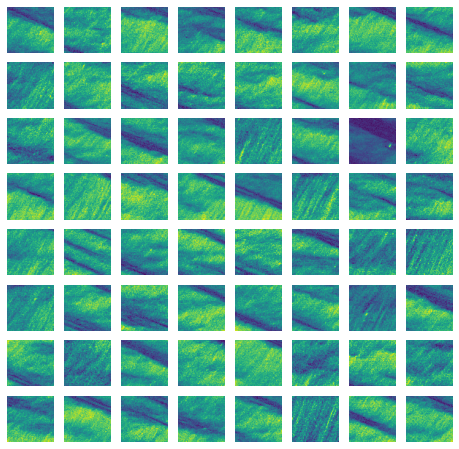

In [9]:
sampling_number = 64
# Suggest to use GPU. Running Annealed Langevin Dynamics in CPU takes extremely long time
# device = "cpu"

# score_fn = Model(n_steps, sigma_min, sigma_max).to(device)
# score_fn.load_state_dict(torch.load('models/score_fn.pth', map_location=device))
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final=True)

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample.cpu().numpy()[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")

plt.savefig("img/NCSN_result.png", dpi=500)
plt.show()